## 1. Setup de ambiente (Python + Jupyter)

# jWEB / PHC — Mock Analytics Notebook

Notebook de trabalho para simular o acesso à BD PHC usando **dados mock**.

Objetivos:
- Simular o modelo relacional típico (Clientes, Artigos, Documentos, Linhas).
- Consolidar tudo numa tabela de **vendas**.
- Calcular KPIs base.
- Gerar visualizações que sirvam de rascunho para o futuro dashboard (Power BI / Metabase / outro).

In [45]:
import pandas as pd
import numpy as np

# Mostrar mais colunas nas tabelas
pd.set_option("display.max_columns", 50)

print("Setup OK")


Setup OK


## 2. Modelo de dados mock (estilo PHC)

Aqui definimos 4 tabelas principais que imitam a estrutura habitual de um ERP:

1. **CLIENTES** – quem compra.
2. **ARTIGOS** – o que é vendido.
3. **DOCUMENTOS DE VENDA** – faturas / documentos comerciais.
4. **LINHAS DE VENDA** – detalhe de cada documento.

Mais tarde estas tabelas seriam substituídas pelas tabelas reais da BD PHC.

### 2.1 Clientes

In [46]:
# ============================
# Tabela CLIENTES (mock PHC)
# ============================

clientes = pd.DataFrame({
    "cliente_id": [1, 2, 3, 4, 5],
    "nome": ["Cliente A", "Cliente B", "Cliente C", "Cliente D", "Cliente E"],
    "nif": ["123456789", "987654321", "192837465", "564738291", "102938475"],
    "segmento": ["Retalho", "Serviços", "Retalho", "Industrial", "Serviços"],
    "cidade": ["Lisboa", "Porto", "Braga", "Coimbra", "Lisboa"]
})

clientes

,cliente_id,nome,nif,segmento,cidade
0,1,Cliente A,123456789,Retalho,Lisboa
1,2,Cliente B,987654321,Serviços,Porto
2,3,Cliente C,192837465,Retalho,Braga
3,4,Cliente D,564738291,Industrial,Coimbra
4,5,Cliente E,102938475,Serviços,Lisboa


### 2.2 Artigos

In [47]:
# ============================
# Tabela ARTIGOS (mock PHC)
# ============================

artigos = pd.DataFrame({
    "artigo_id": [101, 102, 103, 104],
    "descricao": ["Teclado", "Rato", "Monitor 24", "Portátil"],
    "preco_venda": [15.90, 9.99, 129.90, 799.00],
    "categoria": ["Periféricos", "Periféricos", "Monitores", "Computadores"]
})

artigos

,artigo_id,descricao,preco_venda,categoria
0,101,Teclado,15.90,Periféricos
1,102,Rato,9.99,Periféricos
2,103,Monitor 24,129.90,Monitores
3,104,Portátil,799.00,Computadores


### 2.3 Documentos de venda

In [48]:
# ============================
# Tabela DOCUMENTOS DE VENDA (mock PHC)
# ============================

documentos = pd.DataFrame({
    "doc_id": [1001, 1002, 1003, 1004, 1005],
    "cliente_id": [1, 2, 3, 1, 5],    # liga ao cliente
    "data": pd.to_datetime([
        "2025-01-10",
        "2025-01-12",
        "2025-01-15",
        "2025-02-02",
        "2025-02-10"
    ]),
    "tipo_doc": ["FT", "FT", "FT", "FT", "FT"]  # Fatura
})

documentos

,doc_id,cliente_id,data,tipo_doc
0,1001,1,2025-01-10,FT
1,1002,2,2025-01-12,FT
2,1003,3,2025-01-15,FT
3,1004,1,2025-02-02,FT
4,1005,5,2025-02-10,FT


### 2.4 Linhas de venda

In [49]:
# ============================
# Tabela LINHAS DE VENDA (mock PHC)
# ============================

linhas = pd.DataFrame({
    "linha_id": [1, 2, 3, 4, 5, 6, 7],
    "doc_id": [1001, 1001, 1002, 1003, 1004, 1005, 1005],  # faturas
    "artigo_id": [101, 102, 103, 101, 104, 102, 103],       # produtos vendidos
    "quantidade": [2, 1, 1, 3, 1, 2, 1],
})

# Calcular valor total da linha
linhas["valor_total"] = linhas.apply(
    lambda row: row["quantidade"] * artigos.loc[artigos["artigo_id"] == row["artigo_id"], "preco_venda"].values[0],
    axis=1
)

linhas

,linha_id,doc_id,artigo_id,quantidade,valor_total
0,1,1001,101,2,31.80
1,2,1001,102,1,9.99
2,3,1002,103,1,129.90
3,4,1003,101,3,47.70
4,5,1004,104,1,799.00
5,6,1005,102,2,19.98
6,7,1005,103,1,129.90


## 3. Consolidação das tabelas (JOINs)

Aqui simulamos o que irá acontecer na BD PHC real:

- `linhas` ⨝ `artigos`  → adiciona preço e descrição a cada linha.
- `documentos` ⨝ `clientes` → adiciona dados do cliente ao documento.
- Resultado final: tabela **vendas** com toda a informação necessária para KPIs e dashboards.

In [50]:
# ============================
# Consolidação de vendas (JOIN)
# ============================

# Juntar linhas → artigos (para obter o preço e descrição)
linhas_artigos = linhas.merge(artigos, on="artigo_id", how="left")

# Juntar documentos → clientes
docs_clientes = documentos.merge(clientes, on="cliente_id", how="left")

# Juntar tudo
vendas = linhas_artigos.merge(docs_clientes, on="doc_id", how="left")

vendas

,linha_id,doc_id,artigo_id,quantidade,valor_total,descricao,preco_venda,categoria,cliente_id,data,tipo_doc,nome,nif,segmento,cidade
0,1,1001,101,2,31.80,Teclado,15.90,Periféricos,1,2025-01-10,FT,Cliente A,123456789,Retalho,Lisboa
1,2,1001,102,1,9.99,Rato,9.99,Periféricos,1,2025-01-10,FT,Cliente A,123456789,Retalho,Lisboa
2,3,1002,103,1,129.90,Monitor 24,129.90,Monitores,2,2025-01-12,FT,Cliente B,987654321,Serviços,Porto
3,4,1003,101,3,47.70,Teclado,15.90,Periféricos,3,2025-01-15,FT,Cliente C,192837465,Retalho,Braga
4,5,1004,104,1,799.00,Portátil,799.00,Computadores,1,2025-02-02,FT,Cliente A,123456789,Retalho,Lisboa
5,6,1005,102,2,19.98,Rato,9.99,Periféricos,5,2025-02-10,FT,Cliente E,102938475,Serviços,Lisboa
6,7,1005,103,1,129.90,Monitor 24,129.90,Monitores,5,2025-02-10,FT,Cliente E,102938475,Serviços,Lisboa


## 4. KPIs base

KPIs calculados a partir da tabela `vendas`:

1. **Total de faturação**.
2. **Top clientes por faturação**.
3. **Top artigos por faturação**.
4. **Faturação mensal** (YYYY-MM).

Estes KPIs podem ser replicados depois em SQL ou diretamente na ferramenta de BI.

In [51]:
# KPI 1 — Total de faturação
kpi_total_faturacao = vendas["valor_total"].sum()
kpi_total_faturacao

np.float64(1168.27)

In [52]:
# KPI 2 — Top clientes por faturação
kpi_top_clientes = (
    vendas.groupby("nome")["valor_total"]
    .sum()
    .sort_values(ascending=False)
)
kpi_top_clientes

nome
Cliente A    840.79
Cliente E    149.88
Cliente B    129.90
Cliente C     47.70
Name: valor_total, dtype: float64

In [53]:
# KPI 3 — Top artigos por faturação
kpi_top_artigos = (
    vendas.groupby("descricao")["valor_total"]
    .sum()
    .sort_values(ascending=False)
)
kpi_top_artigos

descricao
Portátil      799.00
Monitor 24    259.80
Teclado        79.50
Rato           29.97
Name: valor_total, dtype: float64

In [54]:
# KPI 4 — Vendas por mês (YYYY-MM)
vendas["ano_mes"] = vendas["data"].dt.to_period("M").astype(str)

kpi_vendas_mensais = (
    vendas.groupby("ano_mes")["valor_total"]
    .sum()
    .sort_values()
)
kpi_vendas_mensais

ano_mes
2025-01    219.39
2025-02    948.88
Name: valor_total, dtype: float64

## 5. Visualização tipo "mini-dashboard"

Aqui criamos um layout simples em Matplotlib que junta:

- Top clientes por faturação.
- Top artigos por faturação.
- Faturação mensal.

É apenas um **rascunho visual** para ajudar a desenhar o dashboard final em Power BI / Metabase.

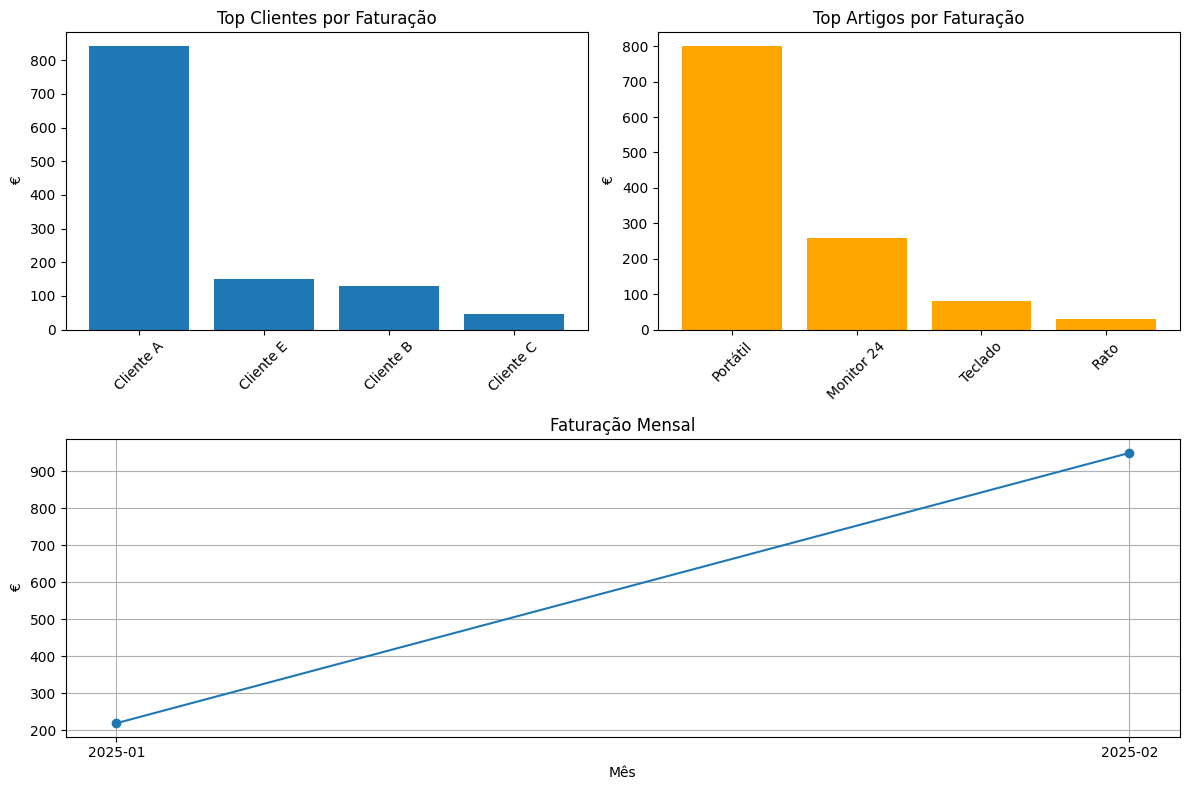

In [55]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Criar layout com 2 linhas e 2 colunas
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 2, figure=fig)

# Gráfico 1 — Faturação por Cliente
ax1 = fig.add_subplot(gs[0, 0])
ax1.bar(kpi_top_clientes.index, kpi_top_clientes.values)
ax1.set_title("Top Clientes por Faturação")
ax1.set_ylabel("€")
ax1.tick_params(axis='x', rotation=45)

# Gráfico 2 — Top Artigos
ax2 = fig.add_subplot(gs[0, 1])
ax2.bar(kpi_top_artigos.index, kpi_top_artigos.values, color="orange")
ax2.set_title("Top Artigos por Faturação")
ax2.set_ylabel("€")
ax2.tick_params(axis='x', rotation=45)

# Gráfico 3 — Faturação Mensal (linha)
ax3 = fig.add_subplot(gs[1, :])
ax3.plot(kpi_vendas_mensais.index, kpi_vendas_mensais.values, marker="o")
ax3.set_title("Faturação Mensal")
ax3.set_ylabel("€")
ax3.set_xlabel("Mês")
ax3.grid(True)

plt.tight_layout()
plt.show()

In [1]:
import numpy as np
import pandas as pd

np.random.seed(42)  # reprodutibilidade

# -------------------------
# DIM_CLIENTE
# -------------------------
n_clientes = 50
dim_cliente = pd.DataFrame({
    "id_cliente": range(1, n_clientes + 1),
    "nome_cliente": [f"Cliente {i}" for i in range(1, n_clientes + 1)],
    "segmento_cliente": np.random.choice(["Retail", "B2B", "Parceiro"], size=n_clientes),
    "cidade": np.random.choice(["Porto", "Lisboa", "Braga", "Coimbra"], size=n_clientes),
    "pais": "Portugal"
})

# -------------------------
# DIM_ARTIGO
# -------------------------
n_artigos = 30
dim_artigo = pd.DataFrame({
    "id_artigo": range(1, n_artigos + 1),
    "nome_artigo": [f"Artigo {i}" for i in range(1, n_artigos + 1)],
    "categoria": np.random.choice(["Software", "Serviço", "Hardware"], size=n_artigos),
    "subcategoria": np.random.choice(["Licença", "Implementação", "Suporte", "Equipamento"], size=n_artigos)
})

# -------------------------
# DIM_VENDEDOR
# -------------------------
n_vendedores = 8
dim_vendedor = pd.DataFrame({
    "id_vendedor": range(1, n_vendedores + 1),
    "nome_vendedor": [f"Vendedor {i}" for i in range(1, n_vendedores + 1)],
    "equipa": np.random.choice(["Norte", "Sul", "Online"], size=n_vendedores)
})

# -------------------------
# DIM_TEMPO
# -------------------------
datas = pd.date_range(start="2024-01-01", end="2024-12-31", freq="D")
dim_tempo = pd.DataFrame({
    "id_tempo": range(1, len(datas) + 1),
    "data": datas,
})
dim_tempo["ano"] = dim_tempo["data"].dt.year
dim_tempo["mes"] = dim_tempo["data"].dt.month
dim_tempo["trimestre"] = dim_tempo["data"].dt.quarter
dim_tempo["dia_semana"] = dim_tempo["data"].dt.day_name(locale="pt_PT")

# -------------------------
# FACT_VENDA
# -------------------------
n_vendas = 3000  # ajusta se quiseres mais/menos registos

fact_venda = pd.DataFrame({
    "id_venda": range(1, n_vendas + 1),
    "id_tempo": np.random.choice(dim_tempo["id_tempo"], size=n_vendas),
    "id_cliente": np.random.choice(dim_cliente["id_cliente"], size=n_vendas),
    "id_artigo": np.random.choice(dim_artigo["id_artigo"], size=n_vendas),
    "id_vendedor": np.random.choice(dim_vendedor["id_vendedor"], size=n_vendas),
    "quantidade": np.random.randint(1, 10, size=n_vendas),
    "preco_unitario": np.random.uniform(50, 1000, size=n_vendas).round(2),
    "desconto_perc": np.random.choice([0, 5, 10, 15, 20], size=n_vendas)
})

# calcula totais
fact_venda["custo_unitario"] = (fact_venda["preco_unitario"] * np.random.uniform(0.4, 0.8, size=n_vendas)).round(2)
fact_venda["total_bruto"] = (fact_venda["quantidade"] * fact_venda["preco_unitario"]).round(2)
fact_venda["total_desconto"] = (fact_venda["total_bruto"] * fact_venda["desconto_perc"] / 100).round(2)
fact_venda["total_liquido"] = (fact_venda["total_bruto"] - fact_venda["total_desconto"]).round(2)
fact_venda["custo_total"] = (fact_venda["quantidade"] * fact_venda["custo_unitario"]).round(2)
fact_venda["margem"] = (fact_venda["total_liquido"] - fact_venda["custo_total"]).round(2)

# quick check
dim_cliente.head(), dim_artigo.head(), dim_vendedor.head(), dim_tempo.head(), fact_venda.head()

(   id_cliente nome_cliente segmento_cliente  cidade      pais
 0           1    Cliente 1         Parceiro  Lisboa  Portugal
 1           2    Cliente 2           Retail   Porto  Portugal
 2           3    Cliente 3         Parceiro  Lisboa  Portugal
 3           4    Cliente 4         Parceiro   Porto  Portugal
 4           5    Cliente 5           Retail  Lisboa  Portugal,
    id_artigo nome_artigo categoria   subcategoria
 0          1    Artigo 1  Software        Licença
 1          2    Artigo 2   Serviço    Equipamento
 2          3    Artigo 3  Hardware    Equipamento
 3          4    Artigo 4  Software  Implementação
 4          5    Artigo 5   Serviço        Licença,
    id_vendedor nome_vendedor  equipa
 0            1    Vendedor 1  Online
 1            2    Vendedor 2   Norte
 2            3    Vendedor 3  Online
 3            4    Vendedor 4  Online
 4            5    Vendedor 5     Sul,
    id_tempo       data   ano  mes  trimestre     dia_semana
 0         1 2024-01-01 

In [2]:
dim_cliente.to_csv("dim_cliente.csv", index=False)
dim_artigo.to_csv("dim_artigo.csv", index=False)
dim_vendedor.to_csv("dim_vendedor.csv", index=False)
dim_tempo.to_csv("dim_tempo.csv", index=False)
fact_venda.to_csv("fact_venda.csv", index=False)

In [3]:
# ==============================
# KPIs principais da dashboard
# ==============================

faturacao_total = fact_join["total_liquido"].sum()
margem_total = fact_join["margem"].sum()
n_vendas = fact_join["id_venda"].nunique()
n_clientes = dim_cliente["id_cliente"].nunique()
n_artigos = dim_artigo["id_artigo"].nunique()

ticket_medio = faturacao_total / n_vendas
faturacao_media_por_cliente = faturacao_total / n_clientes
margem_pct = (margem_total / faturacao_total) * 100

kpi_cards = pd.DataFrame({
    "KPI": [
        "Faturação total (€)",
        "Margem total (€)",
        "Margem (%)",
        "Nº vendas",
        "Nº clientes",
        "Nº artigos",
        "Ticket médio (€)",
        "Faturação média por cliente (€)",
    ],
    "Valor": [
        round(faturacao_total, 2),
        round(margem_total, 2),
        round(margem_pct, 2),
        int(n_vendas),
        int(n_clientes),
        int(n_artigos),
        round(ticket_medio, 2),
        round(faturacao_media_por_cliente, 2),
    ],
})

kpi_cards

NameError: name 'fact_join' is not defined

In [4]:
# DASHBOARD PHC - PIPELINE LIMPO (MOCK STAR SCHEMA)

In [5]:
import numpy as np
import pandas as pd

np.random.seed(42)  # reprodutibilidade

# -------------------------
# DIM_CLIENTE
# -------------------------
n_clientes = 50
dim_cliente = pd.DataFrame({
    "id_cliente": range(1, n_clientes + 1),
    "nome_cliente": [f"Cliente {i}" for i in range(1, n_clientes + 1)],
    "segmento_cliente": np.random.choice(["Retail", "B2B", "Parceiro"], size=n_clientes),
    "cidade": np.random.choice(["Porto", "Lisboa", "Braga", "Coimbra"], size=n_clientes),
    "pais": "Portugal"
})

# -------------------------
# DIM_ARTIGO
# -------------------------
n_artigos = 30
dim_artigo = pd.DataFrame({
    "id_artigo": range(1, n_artigos + 1),
    "nome_artigo": [f"Artigo {i}" for i in range(1, n_artigos + 1)],
    "categoria": np.random.choice(["Software", "Serviço", "Hardware"], size=n_artigos),
    "subcategoria": np.random.choice(["Licença", "Implementação", "Suporte", "Equipamento"], size=n_artigos)
})

# -------------------------
# DIM_VENDEDOR
# -------------------------
n_vendedores = 8
dim_vendedor = pd.DataFrame({
    "id_vendedor": range(1, n_vendedores + 1),
    "nome_vendedor": [f"Vendedor {i}" for i in range(1, n_vendedores + 1)],
    "equipa": np.random.choice(["Norte", "Sul", "Online"], size=n_vendedores)
})

# -------------------------
# DIM_TEMPO
# -------------------------
datas = pd.date_range(start="2024-01-01", end="2024-12-31", freq="D")
dim_tempo = pd.DataFrame({
    "id_tempo": range(1, len(datas) + 1),
    "data": datas,
})
dim_tempo["ano"] = dim_tempo["data"].dt.year
dim_tempo["mes"] = dim_tempo["data"].dt.month
dim_tempo["trimestre"] = dim_tempo["data"].dt.quarter
dim_tempo["dia_semana"] = dim_tempo["data"].dt.day_name(locale="pt_PT")

# -------------------------
# FACT_VENDA
# -------------------------
n_vendas = 3000  # nº de registos de vendas mock

fact_venda = pd.DataFrame({
    "id_venda": range(1, n_vendas + 1),
    "id_tempo": np.random.choice(dim_tempo["id_tempo"], size=n_vendas),
    "id_cliente": np.random.choice(dim_cliente["id_cliente"], size=n_vendas),
    "id_artigo": np.random.choice(dim_artigo["id_artigo"], size=n_vendas),
    "id_vendedor": np.random.choice(dim_vendedor["id_vendedor"], size=n_vendas),
    "quantidade": np.random.randint(1, 10, size=n_vendas),
    "preco_unitario": np.random.uniform(50, 1000, size=n_vendas).round(2),
    "desconto_perc": np.random.choice([0, 5, 10, 15, 20], size=n_vendas)
})

# calcula totais
fact_venda["custo_unitario"] = (fact_venda["preco_unitario"] * np.random.uniform(0.4, 0.8, size=n_vendas)).round(2)
fact_venda["total_bruto"] = (fact_venda["quantidade"] * fact_venda["preco_unitario"]).round(2)
fact_venda["total_desconto"] = (fact_venda["total_bruto"] * fact_venda["desconto_perc"] / 100).round(2)
fact_venda["total_liquido"] = (fact_venda["total_bruto"] - fact_venda["total_desconto"]).round(2)
fact_venda["custo_total"] = (fact_venda["quantidade"] * fact_venda["custo_unitario"]).round(2)
fact_venda["margem"] = (fact_venda["total_liquido"] - fact_venda["custo_total"]).round(2)

# quick check
dim_cliente.head(), dim_artigo.head(), dim_vendedor.head(), dim_tempo.head(), fact_venda.head()

(   id_cliente nome_cliente segmento_cliente  cidade      pais
 0           1    Cliente 1         Parceiro  Lisboa  Portugal
 1           2    Cliente 2           Retail   Porto  Portugal
 2           3    Cliente 3         Parceiro  Lisboa  Portugal
 3           4    Cliente 4         Parceiro   Porto  Portugal
 4           5    Cliente 5           Retail  Lisboa  Portugal,
    id_artigo nome_artigo categoria   subcategoria
 0          1    Artigo 1  Software        Licença
 1          2    Artigo 2   Serviço    Equipamento
 2          3    Artigo 3  Hardware    Equipamento
 3          4    Artigo 4  Software  Implementação
 4          5    Artigo 5   Serviço        Licença,
    id_vendedor nome_vendedor  equipa
 0            1    Vendedor 1  Online
 1            2    Vendedor 2   Norte
 2            3    Vendedor 3  Online
 3            4    Vendedor 4  Online
 4            5    Vendedor 5     Sul,
    id_tempo       data   ano  mes  trimestre     dia_semana
 0         1 2024-01-01 

In [6]:
# ==========================================
# Vista analítica fact_join (fact + dimensões)
# ==========================================

# 1) junta FACT_VENDA com DIM_TEMPO
fact_join = fact_venda.merge(
    dim_tempo[["id_tempo", "data", "ano", "mes", "trimestre"]],
    on="id_tempo",
    how="left"
)

# 2) junta DIM_CLIENTE
fact_join = fact_join.merge(
    dim_cliente[["id_cliente", "nome_cliente", "segmento_cliente", "cidade", "pais"]],
    on="id_cliente",
    how="left"
)

# 3) junta DIM_ARTIGO
fact_join = fact_join.merge(
    dim_artigo[["id_artigo", "nome_artigo", "categoria", "subcategoria"]],
    on="id_artigo",
    how="left"
)

# 4) junta DIM_VENDEDOR
fact_join = fact_join.merge(
    dim_vendedor[["id_vendedor", "nome_vendedor", "equipa"]],
    on="id_vendedor",
    how="left"
)

# 5) inspeção rápida
fact_join.head()

,id_venda,id_tempo,id_cliente,id_artigo,id_vendedor,quantidade,preco_unitario,desconto_perc,custo_unitario,total_bruto,...,trimestre,nome_cliente,segmento_cliente,cidade,pais,nome_artigo,categoria,subcategoria,nome_vendedor,equipa
0,1,63,19,22,4,7,272.33,0,114.37,1906.31,...,1,Cliente 19,B2B,Lisboa,Portugal,Artigo 22,Hardware,Implementação,Vendedor 4,Online
1,2,352,47,30,7,4,608.68,20,378.81,2434.72,...,4,Cliente 47,B2B,Lisboa,Portugal,Artigo 30,Hardware,Suporte,Vendedor 7,Norte
2,3,231,14,23,3,2,592.16,20,241.78,1184.32,...,3,Cliente 14,Parceiro,Braga,Portugal,Artigo 23,Software,Suporte,Vendedor 3,Online
3,4,241,38,8,1,8,510.05,5,225.13,4080.40,...,3,Cliente 38,Parceiro,Lisboa,Portugal,Artigo 8,Software,Suporte,Vendedor 1,Online
4,5,52,36,13,7,5,572.48,15,308.58,2862.40,...,1,Cliente 36,B2B,Lisboa,Portugal,Artigo 13,Software,Equipamento,Vendedor 7,Norte


In [7]:
# ==============================
# KPIs principais da dashboard
# ==============================

faturacao_total = fact_join["total_liquido"].sum()
margem_total = fact_join["margem"].sum()
n_vendas = fact_join["id_venda"].nunique()
n_clientes = dim_cliente["id_cliente"].nunique()
n_artigos = dim_artigo["id_artigo"].nunique()

ticket_medio = faturacao_total / n_vendas
faturacao_media_por_cliente = faturacao_total / n_clientes
margem_pct = (margem_total / faturacao_total) * 100

kpi_cards = pd.DataFrame({
    "KPI": [
        "Faturação total (€)",
        "Margem total (€)",
        "Margem (%)",
        "Nº vendas",
        "Nº clientes",
        "Nº artigos",
        "Ticket médio (€)",
        "Faturação média por cliente (€)",
    ],
    "Valor": [
        round(faturacao_total, 2),
        round(margem_total, 2),
        round(margem_pct, 2),
        int(n_vendas),
        int(n_clientes),
        int(n_artigos),
        round(ticket_medio, 2),
        round(faturacao_media_por_cliente, 2),
    ],
})

kpi_cards

,KPI,Valor
0,Faturação total (€),7138116.43
1,Margem total (€),2411780.94
2,Margem (%),33.79
3,Nº vendas,3000.00
4,Nº clientes,50.00
5,Nº artigos,30.00
6,Ticket médio (€),2379.37
7,Faturação média por cliente (€),142762.33


In [8]:
# ==============================
# Faturação por mês (para gráfico)
# ==============================

# agregação: soma da faturação líquida por ano + mês
faturacao_mes = (
    fact_join
    .groupby(["ano", "mes"], as_index=False)["total_liquido"]
    .sum()
    .sort_values(["ano", "mes"])
)

# coluna de conveniência para eixo X nos gráficos
faturacao_mes["ano_mes"] = (
    faturacao_mes["ano"].astype(str)
    + "-"
    + faturacao_mes["mes"].astype(str).str.zfill(2)
)

faturacao_mes.head()

,ano,mes,total_liquido,ano_mes
0,2024,1,588057.74,2024-01
1,2024,2,537041.30,2024-02
2,2024,3,521348.06,2024-03
3,2024,4,698942.03,2024-04
4,2024,5,619685.70,2024-05


In [9]:
# ==============================
# Faturação por segmento de cliente
# ==============================

faturacao_segmento = (
    fact_join
    .groupby("segmento_cliente", as_index=False)["total_liquido"]
    .sum()
    .sort_values("total_liquido", ascending=False)
)

faturacao_segmento

,segmento_cliente,total_liquido
1,Parceiro,2834676.07
0,B2B,2196840.92
2,Retail,2106599.44


In [10]:
# ==============================
# Faturação por categoria de artigo
# ==============================

faturacao_categoria = (
    fact_join
    .groupby("categoria", as_index=False)["total_liquido"]
    .sum()
    .sort_values("total_liquido", ascending=False)
)

faturacao_categoria

,categoria,total_liquido
2,Software,3578807.48
0,Hardware,2570941.32
1,Serviço,988367.63


In [11]:
# ==============================
# Faturação por categoria de artigo
# ==============================

faturacao_categoria = (
    fact_join
    .groupby("categoria", as_index=False)["total_liquido"]
    .sum()
    .sort_values("total_liquido", ascending=False)
)

faturacao_categoria

,categoria,total_liquido
2,Software,3578807.48
0,Hardware,2570941.32
1,Serviço,988367.63


In [12]:
# ==============================
# Faturação por equipa de vendedor
# ==============================

faturacao_equipa = (
    fact_join
    .groupby("equipa", as_index=False)["total_liquido"]
    .sum()
    .sort_values("total_liquido", ascending=False)
)

faturacao_equipa

,equipa,total_liquido
1,Online,3539070.40
0,Norte,1886419.43
2,Sul,1712626.60


In [13]:
# ==============================
# Top 10 Clientes por Faturação
# ==============================

top_clientes = (
    fact_join
    .groupby(["id_cliente", "nome_cliente"], as_index=False)["total_liquido"]
    .sum()
    .sort_values("total_liquido", ascending=False)
    .head(10)
)

top_clientes

,id_cliente,nome_cliente,total_liquido
16,17,Cliente 17,218705.33
22,23,Cliente 23,206855.96
46,47,Cliente 47,193297.74
48,49,Cliente 49,191845.47
31,32,Cliente 32,188762.43
44,45,Cliente 45,185126.59
27,28,Cliente 28,170431.14
37,38,Cliente 38,162735.42
3,4,Cliente 4,160991.72
10,11,Cliente 11,157935.68


In [14]:
# ==============================
# Top 10 Artigos por Faturação
# ==============================

top_artigos = (
    fact_join
    .groupby(["id_artigo", "nome_artigo"], as_index=False)["total_liquido"]
    .sum()
    .sort_values("total_liquido", ascending=False)
    .head(10)
)

top_artigos

,id_artigo,nome_artigo,total_liquido
22,23,Artigo 23,322392.93
12,13,Artigo 13,298385.50
3,4,Artigo 4,284917.12
24,25,Artigo 25,267370.81
15,16,Artigo 16,267216.40
21,22,Artigo 22,263754.67
25,26,Artigo 26,261752.52
17,18,Artigo 18,256919.98
9,10,Artigo 10,250939.47
1,2,Artigo 2,248611.74


In [15]:
# ==============================
# Top 10 Artigos por Margem
# ==============================

top_artigos_margem = (
    fact_join
    .groupby(["id_artigo", "nome_artigo"], as_index=False)["margem"]
    .sum()
    .sort_values("margem", ascending=False)
    .head(10)
)

top_artigos_margem

,id_artigo,nome_artigo,margem
12,13,Artigo 13,107338.23
22,23,Artigo 23,102474.08
9,10,Artigo 10,100594.91
3,4,Artigo 4,93081.31
25,26,Artigo 26,90668.63
20,21,Artigo 21,89489.90
17,18,Artigo 18,88156.47
21,22,Artigo 22,87549.55
24,25,Artigo 25,85622.58
15,16,Artigo 16,84864.39


In [16]:
# ==============================
# Tabela detalhe para dashboard
# ==============================

colunas_detalhe = [
    "id_venda",
    "data",
    "ano",
    "mes",
    "trimestre",
    "id_cliente",
    "nome_cliente",
    "segmento_cliente",
    "cidade",
    "id_artigo",
    "nome_artigo",
    "categoria",
    "subcategoria",
    "id_vendedor",
    "nome_vendedor",
    "equipa",
    "quantidade",
    "preco_unitario",
    "desconto_perc",
    "total_bruto",
    "total_desconto",
    "total_liquido",
    "custo_total",
    "margem",
]

tabela_detalhe = fact_join[colunas_detalhe].copy()

tabela_detalhe.head()

,id_venda,data,ano,mes,trimestre,id_cliente,nome_cliente,segmento_cliente,cidade,id_artigo,...,nome_vendedor,equipa,quantidade,preco_unitario,desconto_perc,total_bruto,total_desconto,total_liquido,custo_total,margem
0,1,2024-03-03,2024,3,1,19,Cliente 19,B2B,Lisboa,22,...,Vendedor 4,Online,7,272.33,0,1906.31,0.00,1906.31,800.59,1105.72
1,2,2024-12-17,2024,12,4,47,Cliente 47,B2B,Lisboa,30,...,Vendedor 7,Norte,4,608.68,20,2434.72,486.94,1947.78,1515.24,432.54
2,3,2024-08-18,2024,8,3,14,Cliente 14,Parceiro,Braga,23,...,Vendedor 3,Online,2,592.16,20,1184.32,236.86,947.46,483.56,463.90
3,4,2024-08-28,2024,8,3,38,Cliente 38,Parceiro,Lisboa,8,...,Vendedor 1,Online,8,510.05,5,4080.40,204.02,3876.38,1801.04,2075.34
4,5,2024-02-21,2024,2,1,36,Cliente 36,B2B,Lisboa,13,...,Vendedor 7,Norte,5,572.48,15,2862.40,429.36,2433.04,1542.90,890.14


In [17]:
tabela_detalhe.to_csv("tabela_detalhe_vendas.csv", index=False)

In [19]:
# ==============================
# Faturação Mensal (últimos 24 meses)
# ==============================

faturacao_mensal = (
    fact_join
    .groupby(["ano", "mes"], as_index=False)["total_liquido"]
    .sum()
    .sort_values(["ano", "mes"])
)

# Criar coluna de período YYYY-MM
faturacao_mensal["periodo"] = faturacao_mensal["ano"].astype(str) + "-" + faturacao_mensal["mes"].astype(str).str.zfill(2)

faturacao_mensal

,ano,mes,total_liquido,periodo
0,2024,1,588057.74,2024-01
1,2024,2,537041.30,2024-02
2,2024,3,521348.06,2024-03
3,2024,4,698942.03,2024-04
4,2024,5,619685.70,2024-05
5,2024,6,637280.87,2024-06
6,2024,7,553204.44,2024-07
7,2024,8,663779.97,2024-08
8,2024,9,553112.77,2024-09
9,2024,10,583075.13,2024-10


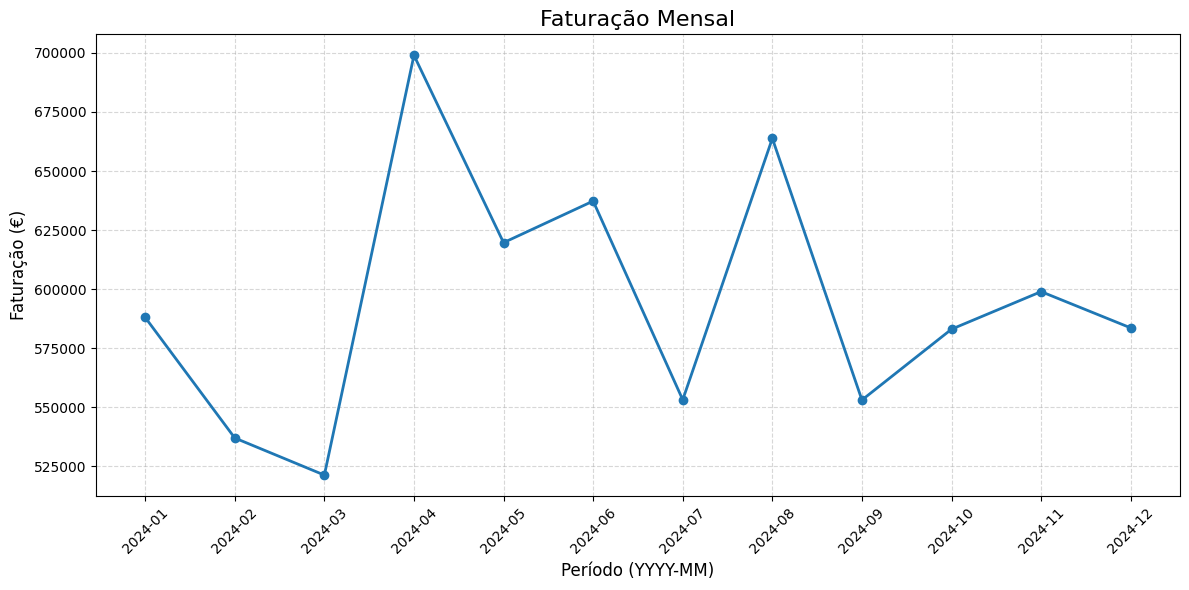

In [20]:
# ==============================
# Gráfico - Faturação Mensal
# ==============================

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.plot(
    faturacao_mensal["periodo"],
    faturacao_mensal["total_liquido"],
    marker="o",
    linewidth=2
)

plt.title("Faturação Mensal", fontsize=16)
plt.xlabel("Período (YYYY-MM)", fontsize=12)
plt.ylabel("Faturação (€)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

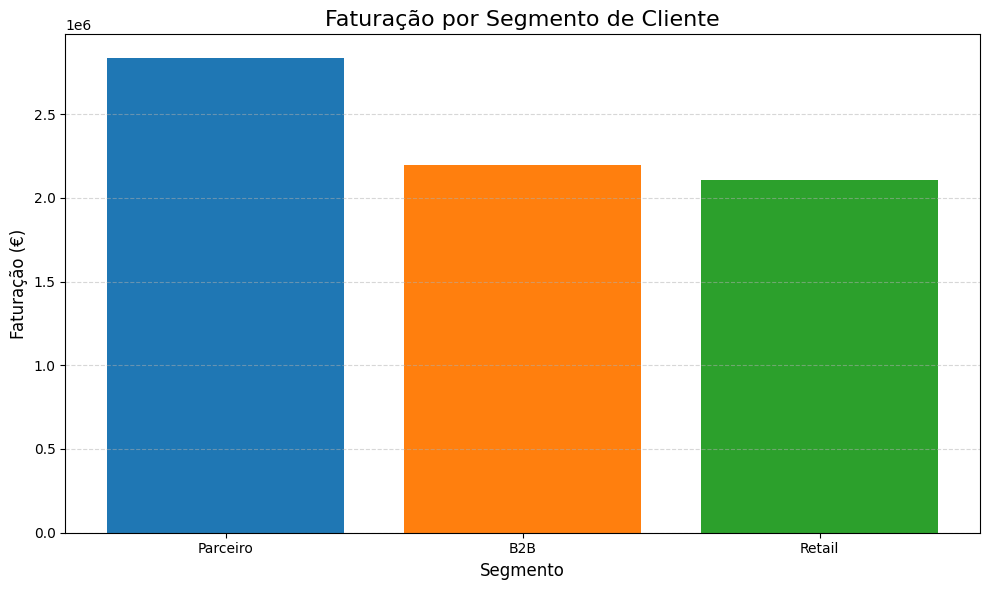

In [21]:
# ==============================
# Gráfico - Faturação por Segmento de Cliente
# ==============================

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.bar(
    faturacao_segmento["segmento_cliente"],
    faturacao_segmento["total_liquido"],
    color=["#1f77b4", "#ff7f0e", "#2ca02c"]  # cores diferentes para cada segmento
)

plt.title("Faturação por Segmento de Cliente", fontsize=16)
plt.xlabel("Segmento", fontsize=12)
plt.ylabel("Faturação (€)", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

In [22]:
# ==============================
# Margem Mensal (valor e %)
# ==============================

margem_mensal = (
    fact_join
    .groupby(["ano", "mes"], as_index=False)[["total_liquido", "margem"]]
    .sum()
    .sort_values(["ano", "mes"])
)

# Coluna período YYYY-MM (igual à faturação_mensal)
margem_mensal["periodo"] = (
    margem_mensal["ano"].astype(str)
    + "-"
    + margem_mensal["mes"].astype(str).str.zfill(2)
)

# Margem em percentagem por mês
margem_mensal["margem_pct"] = (
    margem_mensal["margem"] / margem_mensal["total_liquido"] * 100
).round(2)

margem_mensal

,ano,mes,total_liquido,margem,periodo,margem_pct
0,2024,1,588057.74,210201.91,2024-01,35.75
1,2024,2,537041.30,181492.12,2024-02,33.79
2,2024,3,521348.06,186337.83,2024-03,35.74
3,2024,4,698942.03,230721.64,2024-04,33.01
4,2024,5,619685.70,208857.30,2024-05,33.70
5,2024,6,637280.87,220474.32,2024-06,34.60
6,2024,7,553204.44,188304.70,2024-07,34.04
7,2024,8,663779.97,220018.53,2024-08,33.15
8,2024,9,553112.77,170037.66,2024-09,30.74
9,2024,10,583075.13,197602.21,2024-10,33.89


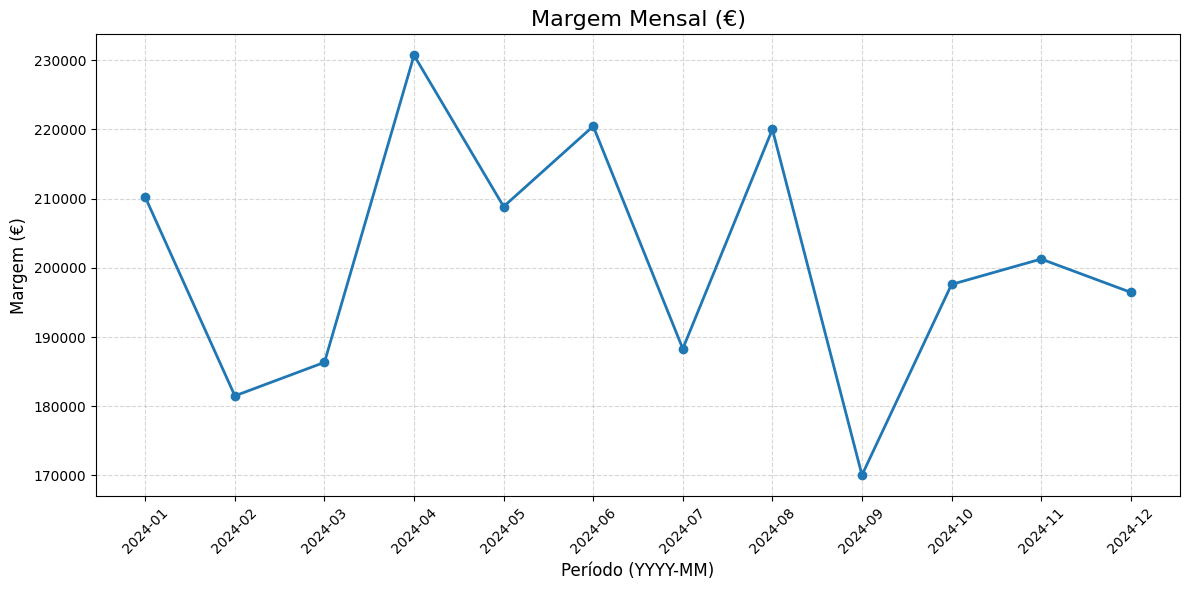

In [23]:
# ==============================
# Gráfico – Margem Mensal (€)
# ==============================

plt.figure(figsize=(12,6))

plt.plot(
    margem_mensal["periodo"],
    margem_mensal["margem"],
    marker="o",
    linewidth=2
)

plt.title("Margem Mensal (€)", fontsize=16)
plt.xlabel("Período (YYYY-MM)", fontsize=12)
plt.ylabel("Margem (€)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

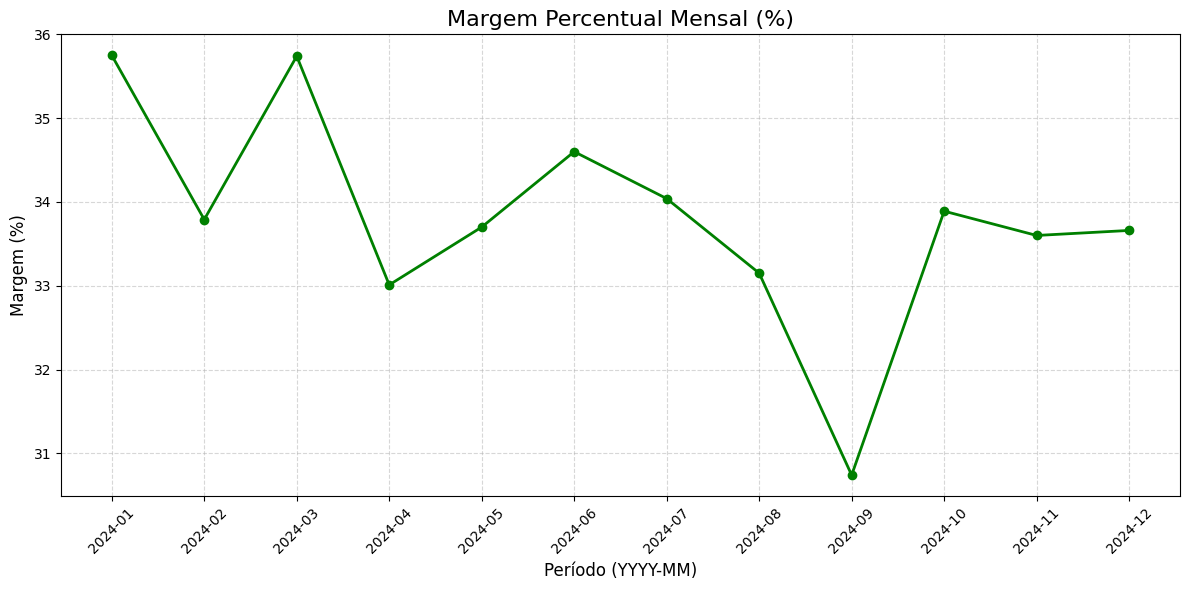

In [24]:
# ==============================
# Gráfico – Margem Percentual (%)
# ==============================

plt.figure(figsize=(12,6))

plt.plot(
    margem_mensal["periodo"],
    margem_mensal["margem_pct"],
    marker="o",
    color="green",
    linewidth=2
)

plt.title("Margem Percentual Mensal (%)", fontsize=16)
plt.xlabel("Período (YYYY-MM)", fontsize=12)
plt.ylabel("Margem (%)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

In [25]:
# ==============================
# Clientes Inativos (>180 dias)
# ==============================

# Última data de venda por cliente
ultima_venda = (
    fact_join.groupby("id_cliente")["data"]
    .max()
    .reset_index()
    .rename(columns={"data": "ultima_data"})
)

# Junta nomes dos clientes
ultima_venda = ultima_venda.merge(
    dim_cliente[["id_cliente", "nome_cliente"]],
    on="id_cliente",
    how="left"
)

# Define data de referência = última data total na base
data_referencia = fact_join["data"].max()

# Calcula inatividade em dias
ultima_venda["dias_inativo"] = (data_referencia - ultima_venda["ultima_data"]).dt.days

# Filtra clientes inativos (> 180 dias)
clientes_inativos = ultima_venda[ultima_venda["dias_inativo"] > 180] \
    .sort_values("dias_inativo", ascending=False)

clientes_inativos

,id_cliente,ultima_data,nome_cliente,dias_inativo


In [26]:
# =====================================
# Concentração de Faturação (Pareto 80/20)
# =====================================

pareto = (
    fact_join.groupby(["id_cliente", "nome_cliente"], as_index=False)["total_liquido"]
    .sum()
    .rename(columns={"total_liquido": "faturacao_total"})
    .sort_values("faturacao_total", ascending=False)
)

# Faturação total global
total_global = pareto["faturacao_total"].sum()

# Percentagem individual
pareto["pct"] = pareto["faturacao_total"] / total_global * 100

# Percentagem acumulada
pareto["pct_acumulado"] = pareto["pct"].cumsum().round(2)

pareto

,id_cliente,nome_cliente,faturacao_total,pct,pct_acumulado
16,17,Cliente 17,218705.33,3.063908,3.06
22,23,Cliente 23,206855.96,2.897907,5.96
46,47,Cliente 47,193297.74,2.707966,8.67
48,49,Cliente 49,191845.47,2.687620,11.36
31,32,Cliente 32,188762.43,2.644429,14.00
44,45,Cliente 45,185126.59,2.593494,16.60
27,28,Cliente 28,170431.14,2.387621,18.98
37,38,Cliente 38,162735.42,2.279809,21.26
3,4,Cliente 4,160991.72,2.255381,23.52
10,11,Cliente 11,157935.68,2.212568,25.73


In [28]:
# =====================================
# Concentração de Faturação (Pareto 80/20)
# =====================================

pareto = (
    fact_join.groupby(["id_cliente", "nome_cliente"], as_index=False)["total_liquido"]
    .sum()
    .rename(columns={"total_liquido": "faturacao_total"})
    .sort_values("faturacao_total", ascending=False)
)

# Faturação total global
total_global = pareto["faturacao_total"].sum()

# Percentagem individual
pareto["pct"] = pareto["faturacao_total"] / total_global * 100

# Percentagem acumulada
pareto["pct_acumulado"] = pareto["pct"].cumsum().round(2)

pareto

,id_cliente,nome_cliente,faturacao_total,pct,pct_acumulado
16,17,Cliente 17,218705.33,3.063908,3.06
22,23,Cliente 23,206855.96,2.897907,5.96
46,47,Cliente 47,193297.74,2.707966,8.67
48,49,Cliente 49,191845.47,2.687620,11.36
31,32,Cliente 32,188762.43,2.644429,14.00
44,45,Cliente 45,185126.59,2.593494,16.60
27,28,Cliente 28,170431.14,2.387621,18.98
37,38,Cliente 38,162735.42,2.279809,21.26
3,4,Cliente 4,160991.72,2.255381,23.52
10,11,Cliente 11,157935.68,2.212568,25.73


In [29]:
# 📘 Plano Técnico — Sistema de KPIs e Analytics PHC

## 1. Objetivo do Projeto
Criar uma estrutura analítica baseada nos dados extraídos do PHC, capaz de gerar KPIs comerciais, financeiros e operacionais, organizados em dashboards reutilizáveis.

---

## 2. Modelo de Dados (Mock PHC)
Foi criado um modelo estrela para simular a base de dados PHC:

### **Dimensões**
- `dim_cliente`: id_cliente, nome_cliente, segmento, cidade, país  
- `dim_artigo`: id_artigo, nome_artigo, categoria, subcategoria  
- `dim_vendedor`: id_vendedor, nome_vendedor, equipa  
- `dim_tempo`: data, ano, mês, trimestre, dia_semana  

### **Tabela Fato**
- `fact_venda`: vendas detalhadas com quantidade, preço, custo, total_liquido, margem, mês/ano e chaves das dimensões.

### **Tabelas exportadas (CSV)**
- `dim_cliente.csv`  
- `dim_artigo.csv`  
- `dim_vendedor.csv`  
- `fact_venda.csv`  
- `tabela_detalhe_vendas.csv`

Estas podem ser carregadas para PostgreSQL, SQLite, Power BI ou qualquer BI.

---

## 3. KPIs Implementados

### **Visão Geral**
- Faturação total  
- Margem total (€)  
- Margem percentual (%)  
- Nº de vendas  
- Nº clientes  
- Nº artigos  
- Ticket médio  
- Faturação média por cliente  
- Tabela `kpi_cards`

### **KPIs Temporais (mensal)**
- `faturacao_mensal`  
- `margem_mensal`  
- `margem_pct` (margem percentual por mês)

### **Clientes**
- `top_clientes` — Top 10 por faturação  
- `clientes_inativos` — Sem compras > 180 dias  
- Faturação por segmento (Retail / B2B / Parceiro)

### **Produtos / Artigos**
- `top_artigos` — Top 10 por faturação  
- `top_artigos_margem` — Top 10 por margem  
- Faturação por categoria  
- Faturação por equipa de vendedor

---

## 4. Dashboards a criar (Power BI / Metabase / Superset)

### **Dashboard 1 — Visão Geral**
- Faturação mensal (linha)
- Margem mensal (€ e %)
- Ticket médio
- KPIs principais (cards)

### **Dashboard 2 — Clientes**
- Top clientes
- Clientes inativos
- Faturação por segmento
- Concentração (Pareto 80/20)

### **Dashboard 3 — Produtos / Serviços**
- Top artigos por faturação
- Top artigos por margem
- Faturação por categoria

### **Filtros globais**
- Ano
- Mês
- Segmento
- Categoria

---

## 5. Próximos Passos (com BD real PHC)

### **Quando a documentação do PHC estiver disponível:**
1. Ler estrutura das tabelas reais.  
2. Ajustar modelo estrela ao PHC real.  
3. Criar scripts de extração (Python + SQLAlchemy ou SQL puro).  
4. Normalizar campos (datas, nomes, duplicados).  
5. Recalcular todos os KPIs diretamente sobre dados reais.  
6. Publicar dashboards com refresh automático.

---

## 6. Entregáveis Prontos (fase mock)
- Modelo de dados
- KPIs calculados
- Tabelas preparadas para BI
- Gráficos exploratórios
- Plano Técnico (este documento)
- Ficheiros CSV exportados

SyntaxError: invalid syntax (2332129860.py, line 4)

# 📘 Plano Técnico — Sistema de KPIs e Analytics PHC

## 1. Objetivo do Projeto
Criar uma estrutura analítica baseada nos dados extraídos do PHC, capaz de gerar KPIs comerciais, financeiros e operacionais, organizados em dashboards reutilizáveis.

---

## 2. Modelo de Dados (Mock PHC)
Foi criado um modelo estrela para simular a base de dados PHC:

### **Dimensões**
- `dim_cliente`: id_cliente, nome_cliente, segmento, cidade, país  
- `dim_artigo`: id_artigo, nome_artigo, categoria, subcategoria  
- `dim_vendedor`: id_vendedor, nome_vendedor, equipa  
- `dim_tempo`: data, ano, mês, trimestre, dia_semana  

### **Tabela Fato**
- `fact_venda`: vendas detalhadas com quantidade, preço, custo, total_liquido, margem, mês/ano e chaves das dimensões.

### **Tabelas exportadas (CSV)**
- `dim_cliente.csv`  
- `dim_artigo.csv`  
- `dim_vendedor.csv`  
- `fact_venda.csv`  
- `tabela_detalhe_vendas.csv`

Estas podem ser carregadas para PostgreSQL, SQLite, Power BI ou qualquer BI.

---

## 3. KPIs Implementados

### **Visão Geral**
- Faturação total  
- Margem total (€)  
- Margem percentual (%)  
- Nº de vendas  
- Nº clientes  
- Nº artigos  
- Ticket médio  
- Faturação média por cliente  
- Tabela `kpi_cards`

### **KPIs Temporais (mensal)**
- `faturacao_mensal`  
- `margem_mensal`  
- `margem_pct` (margem percentual por mês)

### **Clientes**
- `top_clientes` — Top 10 por faturação  
- `clientes_inativos` — Sem compras > 180 dias  
- Faturação por segmento (Retail / B2B / Parceiro)

### **Produtos / Artigos**
- `top_artigos` — Top 10 por faturação  
- `top_artigos_margem` — Top 10 por margem  
- Faturação por categoria  
- Faturação por equipa de vendedor

---

## 4. Dashboards a criar (Power BI / Metabase / Superset)

### **Dashboard 1 — Visão Geral**
- Faturação mensal (linha)
- Margem mensal (€ e %)
- Ticket médio
- KPIs principais (cards)

### **Dashboard 2 — Clientes**
- Top clientes
- Clientes inativos
- Faturação por segmento
- Concentração (Pareto 80/20)

### **Dashboard 3 — Produtos / Serviços**
- Top artigos por faturação
- Top artigos por margem
- Faturação por categoria

### **Filtros globais**
- Ano
- Mês
- Segmento
- Categoria

---

## 5. Próximos Passos (com BD real PHC)

### **Quando a documentação do PHC estiver disponível:**
1. Ler estrutura das tabelas reais.  
2. Ajustar modelo estrela ao PHC real.  
3. Criar scripts de extração (Python + SQLAlchemy ou SQL puro).  
4. Normalizar campos (datas, nomes, duplicados).  
5. Recalcular todos os KPIs diretamente sobre dados reais.  
6. Publicar dashboards com refresh automático.

---

## 6. Entregáveis Prontos (fase mock)
- Modelo de dados
- KPIs calculados
- Tabelas preparadas para BI
- Gráficos exploratórios
- Plano Técnico (este documento)
- Ficheiros CSV exportados

In [30]:
# ==============================
# KPI Cards - Visão Geral
# ==============================

# KPIs base
faturacao_total = fact_join["total_liquido"].sum()
margem_total = fact_join["margem"].sum()
n_vendas = fact_join["id_venda"].nunique()
n_clientes = dim_cliente["id_cliente"].nunique()
n_artigos = dim_artigo["id_artigo"].nunique()

ticket_medio = faturacao_total / n_vendas
faturacao_media_por_cliente = faturacao_total / n_clientes
margem_pct = (margem_total / faturacao_total) * 100

# Tabela de KPI cards
kpi_cards = pd.DataFrame({
    "KPI": [
        "Faturação total (€)",
        "Margem total (€)",
        "Margem (%)",
        "Nº vendas",
        "Nº clientes",
        "Nº artigos",
        "Ticket médio (€)",
        "Faturação média por cliente (€)",
    ],
    "Valor": [
        round(faturacao_total, 2),
        round(margem_total, 2),
        round(margem_pct, 2),
        int(n_vendas),
        int(n_clientes),
        int(n_artigos),
        round(ticket_medio, 2),
        round(faturacao_media_por_cliente, 2),
    ],
})

kpi_cards

,KPI,Valor
0,Faturação total (€),7138116.43
1,Margem total (€),2411780.94
2,Margem (%),33.79
3,Nº vendas,3000.00
4,Nº clientes,50.00
5,Nº artigos,30.00
6,Ticket médio (€),2379.37
7,Faturação média por cliente (€),142762.33


## 📊 Dashboard 1 — Visão Geral

Este dashboard resume o desempenho global da empresa, com base nos dados do PHC (mock):

- Faturação total, margem, nº vendas, nº clientes, nº artigos, ticket médio, faturação média por cliente  
  → Fonte: tabela `kpi_cards`

- Evolução da **faturação mensal (€)**  
  → Fonte: tabela `faturacao_mensal`

- Evolução da **margem mensal (€)**  
  → Fonte: tabela `margem_mensal["margem"]`

- Evolução da **margem percentual mensal (%)**  
  → Fonte: tabela `margem_mensal["margem_pct"]`

Este dashboard responde essencialmente a:
- “Quanto vendemos por mês?”
- “Qual é a margem em valor e em percentagem?”
- “O negócio está estável ou a crescer ao longo do ano?”

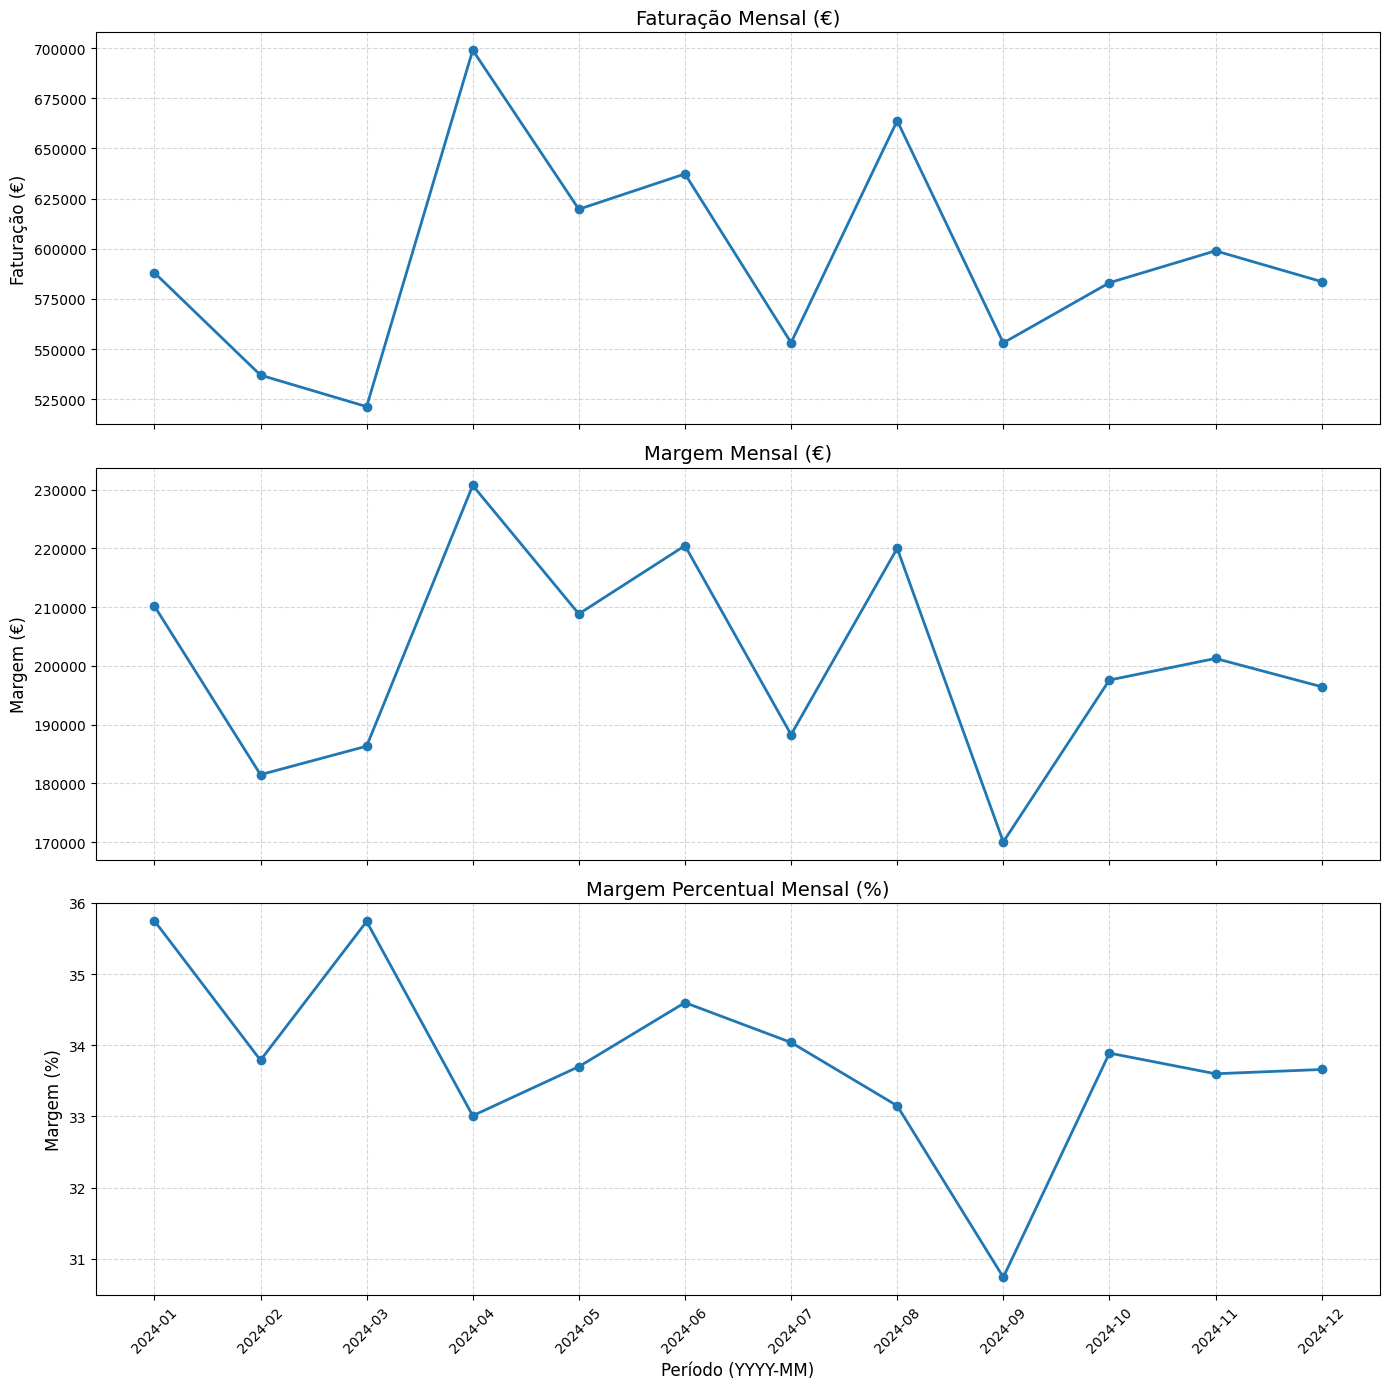

In [31]:
# ==============================
# Dashboard 1 — Visão Geral (gráficos)
# Usa os dataframes já criados:
#   - faturacao_mensal
#   - margem_mensal
# ==============================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(14, 14), sharex=True)

# --- Gráfico 1: Faturação Mensal (€)
axes[0].plot(
    faturacao_mensal["periodo"],
    faturacao_mensal["total_liquido"],
    marker="o",
    linewidth=2,
)
axes[0].set_title("Faturação Mensal (€)", fontsize=14)
axes[0].set_ylabel("Faturação (€)", fontsize=12)
axes[0].grid(True, linestyle="--", alpha=0.5)

# --- Gráfico 2: Margem Mensal (€)
axes[1].plot(
    margem_mensal["periodo"],
    margem_mensal["margem"],
    marker="o",
    linewidth=2,
)
axes[1].set_title("Margem Mensal (€)", fontsize=14)
axes[1].set_ylabel("Margem (€)", fontsize=12)
axes[1].grid(True, linestyle="--", alpha=0.5)

# --- Gráfico 3: Margem Percentual Mensal (%)
axes[2].plot(
    margem_mensal["periodo"],
    margem_mensal["margem_pct"],
    marker="o",
    linewidth=2,
)
axes[2].set_title("Margem Percentual Mensal (%)", fontsize=14)
axes[2].set_xlabel("Período (YYYY-MM)", fontsize=12)
axes[2].set_ylabel("Margem (%)", fontsize=12)
axes[2].grid(True, linestyle="--", alpha=0.5)
axes[2].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

## 📊 Dashboard 2 — Clientes

Este dashboard analisa o comportamento dos clientes, com foco em:
- Top clientes por faturação;
- Clientes inativos (sem compras há mais de 180 dias);
- Concentração de faturação (regra de Pareto 80/20);
- Segmentação por tipo de cliente (B2B, Retail, Parceiro).

Os dados são calculados a partir da tabela `fact_join` (vendas) ligada à dimensão `dim_cliente`.

In [32]:
# ==============================
# Top 10 Clientes por Faturação
# ==============================

# Tabela TOP 10 (id_cliente, nome_cliente, total_liquido)
top_clientes = (
    fact_join
    .groupby(["id_cliente", "nome_cliente"], as_index=False)["total_liquido"]
    .sum()
    .sort_values("total_liquido", ascending=False)
    .head(10)
)

top_clientes

,id_cliente,nome_cliente,total_liquido
16,17,Cliente 17,218705.33
22,23,Cliente 23,206855.96
46,47,Cliente 47,193297.74
48,49,Cliente 49,191845.47
31,32,Cliente 32,188762.43
44,45,Cliente 45,185126.59
27,28,Cliente 28,170431.14
37,38,Cliente 38,162735.42
3,4,Cliente 4,160991.72
10,11,Cliente 11,157935.68


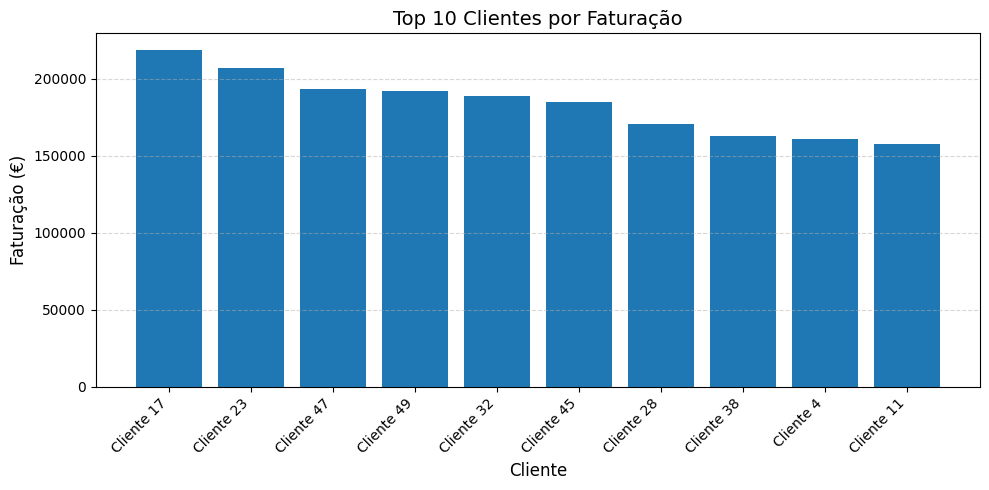

In [33]:
# Gráfico de barras — Top 10 Clientes

plt.figure(figsize=(10, 5))

plt.bar(
    top_clientes["nome_cliente"],
    top_clientes["total_liquido"]
)

plt.title("Top 10 Clientes por Faturação", fontsize=14)
plt.xlabel("Cliente", fontsize=12)
plt.ylabel("Faturação (€)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

In [34]:
# ==============================
# Clientes Inativos (> 180 dias)
# ==============================

# Última data de venda por cliente
ultima_venda = (
    fact_join
    .groupby("id_cliente")["data"]
    .max()
    .reset_index()
    .rename(columns={"data": "ultima_data"})
)

# Junta nome do cliente
ultima_venda = ultima_venda.merge(
    dim_cliente[["id_cliente", "nome_cliente"]],
    on="id_cliente",
    how="left"
)

# Data de referência = data mais recente da base
data_referencia = fact_join["data"].max()

# Quantos dias desde a última compra
ultima_venda["dias_inativo"] = (data_referencia - ultima_venda["ultima_data"]).dt.days

# Filtra clientes com mais de 180 dias sem compras
clientes_inativos = (
    ultima_venda[ultima_venda["dias_inativo"] > 180]
    .sort_values("dias_inativo", ascending=False)
)

clientes_inativos.head(20)

,id_cliente,ultima_data,nome_cliente,dias_inativo


In [35]:
# ==============================
# Concentração de Faturação (Pareto 80/20)
# ==============================

# Faturação por cliente
faturacao_cliente = (
    fact_join
    .groupby(["id_cliente", "nome_cliente"], as_index=False)["total_liquido"]
    .sum()
    .sort_values("total_liquido", ascending=False)
)

# Total global
total_global = faturacao_cliente["total_liquido"].sum()

# Percentagem e percentagem acumulada
faturacao_cliente["pct"] = faturacao_cliente["total_liquido"] / total_global * 100
faturacao_cliente["pct_acum"] = faturacao_cliente["pct"].cumsum()

# Quantos clientes fazem até 80% da faturação?
clientes_80 = faturacao_cliente[faturacao_cliente["pct_acum"] <= 80]
n_clientes_80 = len(clientes_80)
pct_clientes_80 = n_clientes_80 / faturacao_cliente.shape[0] * 100

print(f"Clientes necessários para chegar a 80% da faturação: {n_clientes_80}")
print(f"Isto representa {pct_clientes_80:.1f}% da base total de clientes.")

Clientes necessários para chegar a 80% da faturação: 37
Isto representa 74.0% da base total de clientes.


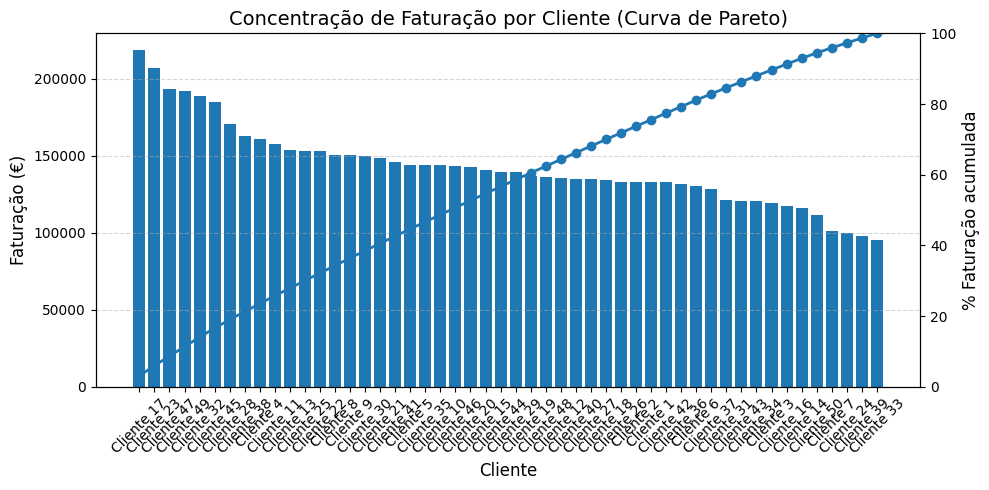

In [36]:
# Gráfico de Pareto (barras + linha de % acumulada)

fig, ax1 = plt.subplots(figsize=(10, 5))

# Barras: faturação por cliente (eixo esquerdo)
ax1.bar(
    faturacao_cliente["nome_cliente"],
    faturacao_cliente["total_liquido"]
)
ax1.set_xlabel("Cliente", fontsize=12)
ax1.set_ylabel("Faturação (€)", fontsize=12)
ax1.tick_params(axis="x", rotation=45, labelrotation=45)
ax1.grid(axis="y", linestyle="--", alpha=0.5)

# Linha: percentagem acumulada (eixo direito)
ax2 = ax1.twinx()
ax2.plot(
    faturacao_cliente["nome_cliente"],
    faturacao_cliente["pct_acum"],
    marker="o",
    linewidth=2
)
ax2.set_ylabel("% Faturação acumulada", fontsize=12)
ax2.set_ylim(0, 100)

plt.title("Concentração de Faturação por Cliente (Curva de Pareto)", fontsize=14)
fig.tight_layout()
plt.show()

In [37]:
# ==============================
# Faturação por Cliente (Ranking Completo)
# ==============================

faturacao_cliente = (
    fact_join
    .groupby(["id_cliente", "nome_cliente"], as_index=False)["total_liquido"]
    .sum()
    .sort_values("total_liquido", ascending=False)
)

faturacao_cliente.head(10)  # mostra o top 10

,id_cliente,nome_cliente,total_liquido
16,17,Cliente 17,218705.33
22,23,Cliente 23,206855.96
46,47,Cliente 47,193297.74
48,49,Cliente 49,191845.47
31,32,Cliente 32,188762.43
44,45,Cliente 45,185126.59
27,28,Cliente 28,170431.14
37,38,Cliente 38,162735.42
3,4,Cliente 4,160991.72
10,11,Cliente 11,157935.68


In [38]:
# Ranking correto de faturação por cliente
faturacao_cliente = (
    fact_join
    .groupby(["id_cliente", "nome_cliente"], as_index=False)
    .agg({"total_liquido": "sum"})
    .sort_values("total_liquido", ascending=False)
)

faturacao_cliente.head(10)

,id_cliente,nome_cliente,total_liquido
16,17,Cliente 17,218705.33
22,23,Cliente 23,206855.96
46,47,Cliente 47,193297.74
48,49,Cliente 49,191845.47
31,32,Cliente 32,188762.43
44,45,Cliente 45,185126.59
27,28,Cliente 28,170431.14
37,38,Cliente 38,162735.42
3,4,Cliente 4,160991.72
10,11,Cliente 11,157935.68


In [39]:
faturacao_cliente = faturacao_cliente.reset_index(drop=True)
faturacao_cliente.index += 1  # começa em 1
faturacao_cliente.head(10)

,id_cliente,nome_cliente,total_liquido
1,17,Cliente 17,218705.33
2,23,Cliente 23,206855.96
3,47,Cliente 47,193297.74
4,49,Cliente 49,191845.47
5,32,Cliente 32,188762.43
6,45,Cliente 45,185126.59
7,28,Cliente 28,170431.14
8,38,Cliente 38,162735.42
9,4,Cliente 4,160991.72
10,11,Cliente 11,157935.68


In [40]:
# ==========================================================
# Pareto 80/20 - Clientes
# ==========================================================

pareto = (
    faturacao_cliente
    .sort_values("total_liquido", ascending=False)
    .assign(pct=lambda x: x["total_liquido"] / x["total_liquido"].sum())
    .assign(pct_acum=lambda x: x["pct"].cumsum())
)

pareto.head(15)

,id_cliente,nome_cliente,total_liquido,pct,pct_acum
1,17,Cliente 17,218705.33,0.030639,0.030639
2,23,Cliente 23,206855.96,0.028979,0.059618
3,47,Cliente 47,193297.74,0.027080,0.086698
4,49,Cliente 49,191845.47,0.026876,0.113574
5,32,Cliente 32,188762.43,0.026444,0.140018
6,45,Cliente 45,185126.59,0.025935,0.165953
7,28,Cliente 28,170431.14,0.023876,0.189829
8,38,Cliente 38,162735.42,0.022798,0.212628
9,4,Cliente 4,160991.72,0.022554,0.235181
10,11,Cliente 11,157935.68,0.022126,0.257307


In [41]:
# Número de clientes necessários para atingir 80% da receita
clientes_80 = pareto.query("pct_acum <= 0.80").shape[0]
clientes_80

37

In [42]:
# ==========================================================
# Segmentação ABC
# ==========================================================

def classificar_abc(p):
    if p <= 0.80:
        return "A"     # clientes críticos
    elif p <= 0.95:
        return "B"     # importantes mas não críticos
    else:
        return "C"     # baixo impacto

pareto["segmento"] = pareto["pct_acum"].apply(classificar_abc)

pareto.head(15)

,id_cliente,nome_cliente,total_liquido,pct,pct_acum,segmento
1,17,Cliente 17,218705.33,0.030639,0.030639,A
2,23,Cliente 23,206855.96,0.028979,0.059618,A
3,47,Cliente 47,193297.74,0.027080,0.086698,A
4,49,Cliente 49,191845.47,0.026876,0.113574,A
5,32,Cliente 32,188762.43,0.026444,0.140018,A
6,45,Cliente 45,185126.59,0.025935,0.165953,A
7,28,Cliente 28,170431.14,0.023876,0.189829,A
8,38,Cliente 38,162735.42,0.022798,0.212628,A
9,4,Cliente 4,160991.72,0.022554,0.235181,A
10,11,Cliente 11,157935.68,0.022126,0.257307,A


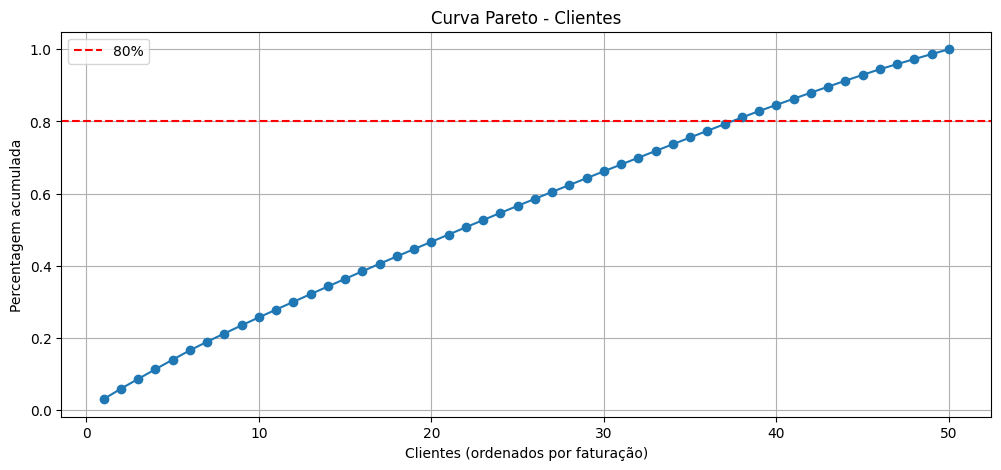

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.plot(pareto.index, pareto["pct_acum"], marker="o")
plt.axhline(0.80, color="red", linestyle="--", label="80%")
plt.title("Curva Pareto - Clientes")
plt.xlabel("Clientes (ordenados por faturação)")
plt.ylabel("Percentagem acumulada")
plt.legend()
plt.grid(True)
plt.show()

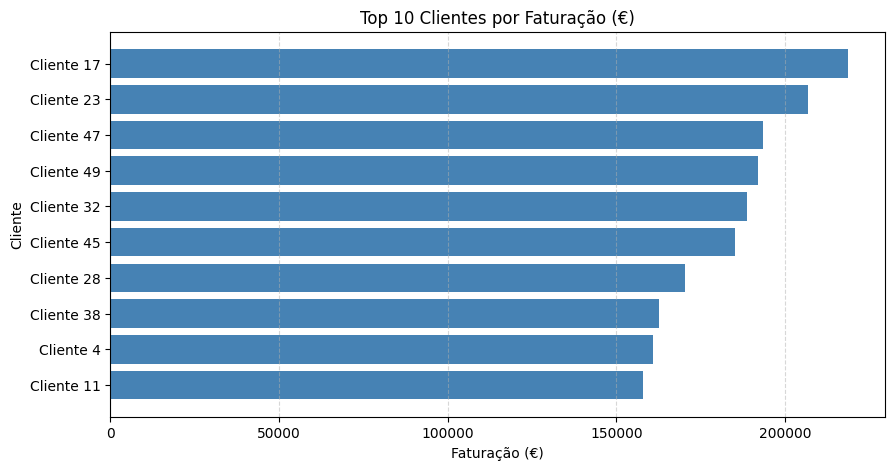

In [44]:
# =========================================
# Gráfico: Top 10 Clientes por Faturação
# =========================================

top10 = faturacao_cliente.head(10)

plt.figure(figsize=(10,5))
plt.barh(top10["nome_cliente"], top10["total_liquido"], color="steelblue")
plt.gca().invert_yaxis()
plt.title("Top 10 Clientes por Faturação (€)")
plt.xlabel("Faturação (€)")
plt.ylabel("Cliente")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.show()

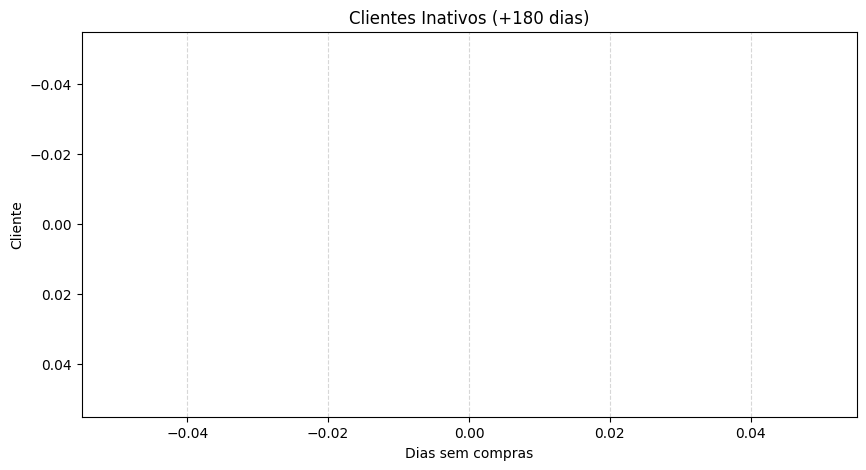

In [45]:
# ================================
# Gráfico: Clientes Inativos (>180 dias)
# ================================

clientes_inativos_plot = clientes_inativos.copy()
clientes_inativos_plot["nome"] = clientes_inativos_plot["nome_cliente"]

plt.figure(figsize=(10,5))
plt.barh(clientes_inativos_plot["nome"], clientes_inativos_plot["dias_inativo"], color="salmon")
plt.gca().invert_yaxis()

plt.title("Clientes Inativos (+180 dias)")
plt.xlabel("Dias sem compras")
plt.ylabel("Cliente")
plt.grid(axis="x", linestyle="--", alpha=0.5)

plt.show()

In [46]:
# ================================
# Distribuição por Segmento (ABC) - contagem
# ================================
pareto["segmento"].value_counts()

segmento
A    37
B     9
C     4
Name: count, dtype: int64

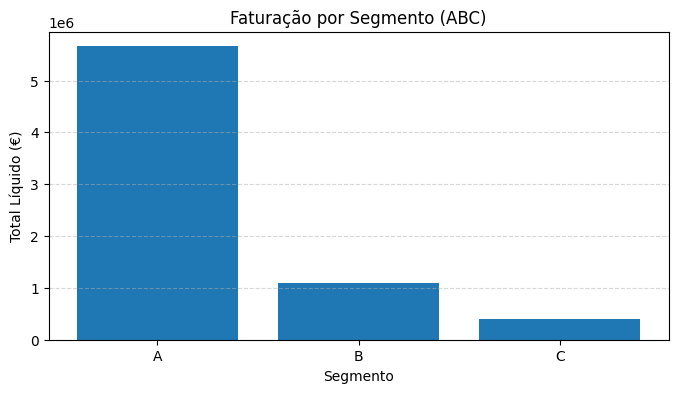

,segmento,total_liquido
0,A,5658228.52
1,B,1085066.06
2,C,394821.85


In [47]:
# ================================
# Gráfico: Faturação por Segmento (ABC)
# ================================

fat_segmento = (
    pareto.groupby("segmento", as_index=False)["total_liquido"]
    .sum()
    .sort_values("total_liquido", ascending=False)
)

plt.figure(figsize=(8,4))
plt.bar(fat_segmento["segmento"], fat_segmento["total_liquido"])
plt.title("Faturação por Segmento (ABC)")
plt.xlabel("Segmento")
plt.ylabel("Total Líquido (€)")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

fat_segmento

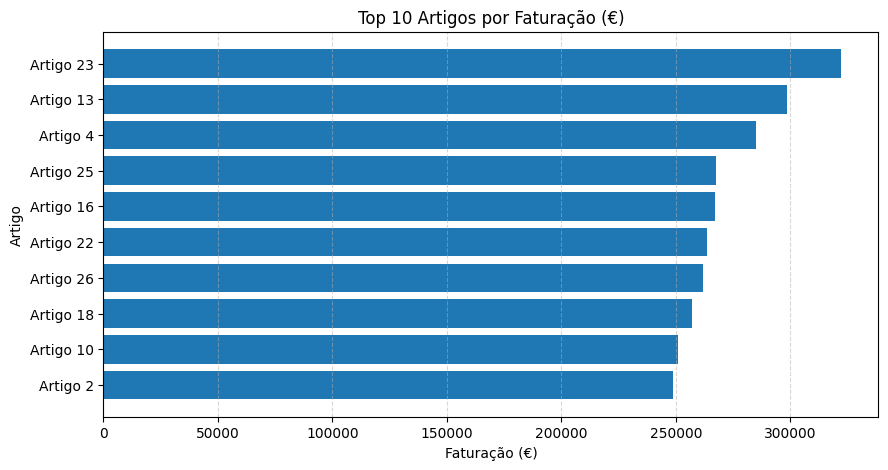

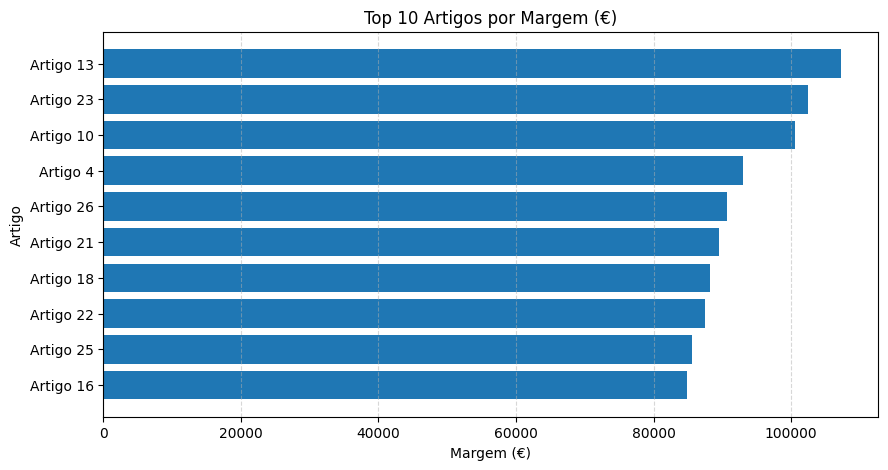

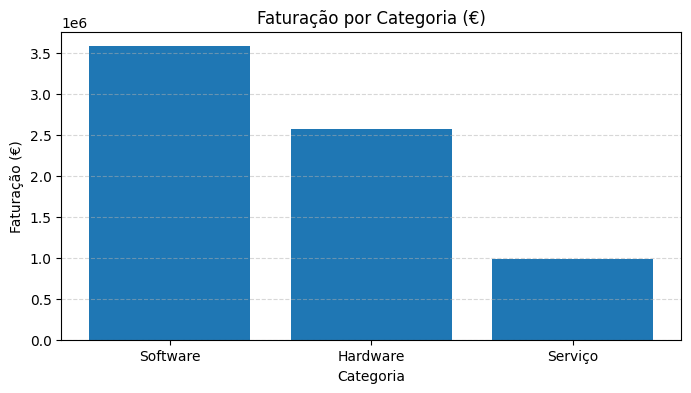

In [48]:
# =========================================
# Dashboard 3 — Produtos / Serviços
# =========================================

import matplotlib.pyplot as plt

# 1) Top 10 Artigos por Faturação
fat_artigo = (
    fact_join.groupby(["id_artigo", "nome_artigo"], as_index=False)["total_liquido"]
    .sum()
    .sort_values("total_liquido", ascending=False)
)

top10_artigos_fat = fat_artigo.head(10)

plt.figure(figsize=(10,5))
plt.barh(top10_artigos_fat["nome_artigo"], top10_artigos_fat["total_liquido"])
plt.gca().invert_yaxis()
plt.title("Top 10 Artigos por Faturação (€)")
plt.xlabel("Faturação (€)")
plt.ylabel("Artigo")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.show()

top10_artigos_fat


# 2) Top 10 Artigos por Margem (€)
marg_artigo = (
    fact_join.groupby(["id_artigo", "nome_artigo"], as_index=False)["margem"]
    .sum()
    .sort_values("margem", ascending=False)
)

top10_artigos_marg = marg_artigo.head(10)

plt.figure(figsize=(10,5))
plt.barh(top10_artigos_marg["nome_artigo"], top10_artigos_marg["margem"])
plt.gca().invert_yaxis()
plt.title("Top 10 Artigos por Margem (€)")
plt.xlabel("Margem (€)")
plt.ylabel("Artigo")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.show()

top10_artigos_marg


# 3) Faturação por Categoria (se existir coluna categoria em fact_join)
if "categoria" in fact_join.columns:
    fat_categoria = (
        fact_join.groupby("categoria", as_index=False)["total_liquido"]
        .sum()
        .sort_values("total_liquido", ascending=False)
    )

    plt.figure(figsize=(8,4))
    plt.bar(fat_categoria["categoria"], fat_categoria["total_liquido"])
    plt.title("Faturação por Categoria (€)")
    plt.xlabel("Categoria")
    plt.ylabel("Faturação (€)")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()

    fat_categoria
else:
    print("⚠️ A coluna 'categoria' não está em fact_join. Diz-me onde tens 'categoria' (dim_artigo?) que eu ajusto o merge.")

In [52]:
from pathlib import Path

OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

# 1. KPI Cards
kpi_cards.to_csv(OUTPUT_DIR / "kpi_cards.csv", index=False)

# 2. Faturação mensal
faturacao_mensal.to_csv(OUTPUT_DIR / "faturacao_mensal.csv", index=False)

# 3. Margem mensal
margem_mensal.to_csv(OUTPUT_DIR / "margem_mensal.csv", index=False)

# 4. Top clientes
top_clientes.to_csv(OUTPUT_DIR / "top_clientes.csv", index=False)

# 5. Clientes inativos
clientes_inativos.to_csv(OUTPUT_DIR / "clientes_inativos.csv", index=False)

# 6. Top artigos por faturação
top_artigos.to_csv(OUTPUT_DIR / "top_artigos.csv", index=False)

# 7. Top artigos por margem
top_artigos_margem.to_csv(OUTPUT_DIR / "top_artigos_margem.csv", index=False)

print("✅ CSVs exportados com sucesso para /outputs")

✅ CSVs exportados com sucesso para /outputs


In [50]:
# Ver variáveis parecidas com "top_artigos"
[k for k in globals().keys() if "top" in k and "art" in k]

['top_artigos',
 'top_artigos_margem',
 'top10_artigos_fat',
 'top10_artigos_marg']

In [53]:
from pathlib import Path

OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

kpi_cards.to_csv(OUTPUT_DIR / "kpi_cards.csv", index=False)
faturacao_mensal.to_csv(OUTPUT_DIR / "faturacao_mensal.csv", index=False)
margem_mensal.to_csv(OUTPUT_DIR / "margem_mensal.csv", index=False)
top_clientes.to_csv(OUTPUT_DIR / "top_clientes.csv", index=False)
clientes_inativos.to_csv(OUTPUT_DIR / "clientes_inativos.csv", index=False)
top_artigos.to_csv(OUTPUT_DIR / "top_artigos.csv", index=False)
top_artigos_margem.to_csv(OUTPUT_DIR / "top_artigos_margem.csv", index=False)

print("CSVs exportados para /outputs")

CSVs exportados para /outputs
